# Aprendizado Supervisionado

Jaime Hikaru Mishima

nome.sobrenome@gmail.com

## Previsão de Cancelamento de cartão
A ideia é prever o cancelamento de cartão.

## 0. Importar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt
import fklearn, matplotlib

# Variable selection based on Filter
from sklearn.feature_selection import SelectKBest, chi2 
from sklearn.preprocessing import MinMaxScaler

# Variable selection base on Wrapper
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Variable selection based on Random Forest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

## 1. Base de Modelagem

**Base de modelagem** contendo os dados de ambas as bases e com a variável resposta

**Target 1**: Quem cancelou o cartão de crédito

In [7]:
dados_cancelamento = pd.read_csv('CartaoCredito_cancelamento.csv')
dados_cancelamento.drop(columns=['ID'], inplace=True)
dados_cancelamento['Target'] = 1
dados_cancelamento['Anuidade'] = dados_cancelamento['Anuidade'].str.replace(',', '.').astype(float)
dados_cancelamento.head()

,PerfilEconomico,Sexo,Idade,PerfilCompra,ValorCompraAnual,GastoMax,GastoMedio,UF,CidadeResidencia,RegiaodoPais,NumeroComprasOnline,MesesDesempregado,Anuidade,Target
0,2,mulher,24,2,1875,133.928571,156.250000,MA,Centro Novo do Maranhão,Região Nordeste,13.020833,2,251.193871,1
1,3,mulher,22,0,725,51.785714,60.416667,PI,Amarante,Região Nordeste,5.492424,13,233.543941,1
2,3,homem,22,0,72292,5163.714286,6024.333333,MT,Santo Antônio do Leverger,Região Centro-Oeste,547.666667,2,275.436944,1
3,3,homem,22,1,155,11.071429,12.916667,PR,Quitandinha,Região Sul,1.174242,13,2.003111,1
4,2,mulher,15,1,26,1.857143,2.166667,SP,Nova Campina,Região Sudeste,0.288889,7,249.334689,1


**Target 0**: Quem não cancelou o cartão de crédito 

In [8]:
dados_sem_cancelamento = pd.read_csv('CartaoCredito_semtarget.csv')
dados_sem_cancelamento.drop(columns=['ID'], inplace=True)
dados_sem_cancelamento['Target'] = 0
dados_sem_cancelamento['Anuidade'] = dados_sem_cancelamento['Anuidade'].str.replace(',', '.').astype(float)
dados_sem_cancelamento.head()

,PerfilEconomico,Sexo,Idade,PerfilCompra,ValorCompraAnual,GastoMax,GastoMedio,UF,CidadeResidencia,RegiaodoPais,NumeroComprasOnline,MesesDesempregado,Anuidade,Target
0,3,homem,22,1,7250.0,517.857143,604.166667,MG,Morada Nova de Minas,Região Sudeste,54.924242,5,62.930401,0
1,1,mulher,38,1,71283.0,5091.642857,5940.250000,RN,Marcelino Vieira,Região Nordeste,312.644737,7,37.915346,0
2,3,mulher,26,0,7925.0,566.071429,660.416667,PR,Agudos do Sul,Região Sul,50.801282,6,60.999319,0
3,1,mulher,35,1,531.0,37.928571,44.250000,PR,Congonhinhas,Região Sul,2.528571,7,5.394438,0
4,3,homem,35,0,805.0,57.500000,67.083333,BA,Morpará,Região Nordeste,3.833333,0,40.996475,0


**Base final**: Dados concatenados

In [9]:
dados = pd.concat([dados_cancelamento, dados_sem_cancelamento])
dados.head()

,PerfilEconomico,Sexo,Idade,PerfilCompra,ValorCompraAnual,GastoMax,GastoMedio,UF,CidadeResidencia,RegiaodoPais,NumeroComprasOnline,MesesDesempregado,Anuidade,Target
0,2,mulher,24,2,1875.0,133.928571,156.250000,MA,Centro Novo do Maranhão,Região Nordeste,13.020833,2,251.193871,1
1,3,mulher,22,0,725.0,51.785714,60.416667,PI,Amarante,Região Nordeste,5.492424,13,233.543941,1
2,3,homem,22,0,72292.0,5163.714286,6024.333333,MT,Santo Antônio do Leverger,Região Centro-Oeste,547.666667,2,275.436944,1
3,3,homem,22,1,155.0,11.071429,12.916667,PR,Quitandinha,Região Sul,1.174242,13,2.003111,1
4,2,mulher,15,1,26.0,1.857143,2.166667,SP,Nova Campina,Região Sudeste,0.288889,7,249.334689,1


## 2. EDA da Base

Análise exploratória serve para desvendar um pouco do processo gerador de dados. Quanto mais souber sobre como os dados são gerados, melhor será as chances de usar a técnica de modelagem mais adequada. Algumas análises são padrões em todos os processos de análise exploratória:

1. Análise de distribuição. Ex: qual a média, mínimo e máximo de cada variável
2. Análise de dados faltantes. Ex: Quais variáveis têm dados faltantes? Qual a proporção de dados faltantes por variável? Porque esses dados estão faltando? É um bug ou uma característica do processo gerador de dados?
3. Variáveis categóricas. Existem variáveis categóricas? Qual a cardinalidade das variáveis categóricas? As categorias são ordenadas ou sem ordem?
4. Correlação. Qual a correlação entre variáveis?
5. Censura: Quais as limitações do target? Há algum processo de espera temporal entre a observação das variáveis e a observação do target (em problemas de previsão, a resposta geralmente é sim!). Como é esse processo. Há alguma outra variável que limite o target?

### 2.1 Análise de distribuição
Observamos alguns valores estranhos, por exemplo `ValorCompraAnual` com máximo de `5123292` e `NumeroComprasOnline` com máximo de `34107625`.

Provavelmente não são valores de compras anuais e número de compras online reais dos clientes.

In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dados.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PerfilEconomico,1191.00,2.29,0.84,1.00,2.00,3.00,3.00,3.00
Idade,1191.00,30.27,12.36,10.00,22.00,26.00,36.00,92.00
PerfilCompra,1191.00,0.53,1.08,0.00,0.00,0.00,1.00,8.00
ValorCompraAnual,1163.00,108034.13,366794.50,0.00,167.00,2625.00,78667.00,5123292.00
GastoMax,1191.00,7834.60,26481.77,0.00,11.71,187.50,5610.14,365949.43
GastoMedio,1191.00,9140.37,30895.40,0.00,13.67,218.75,6545.17,426941.00
NumeroComprasOnline,1191.00,66806.38,1404381.47,0.00,1.16,13.21,559.97,34107625.00
MesesDesempregado,1191.00,5.09,3.48,0.00,2.00,5.00,8.00,14.00
Anuidade,1191.00,83.57,69.07,0.01,33.55,69.10,107.13,309.38
Target,1191.00,0.25,0.43,0.00,0.00,0.00,1.00,1.00


### 2.2 Valores Nulos
Podemos ver que ValorCompraAnual tem valores nulos

In [12]:
dados.isna().mean()

PerfilEconomico       0.00
Sexo                  0.00
Idade                 0.00
PerfilCompra          0.00
ValorCompraAnual      0.02
GastoMax              0.00
GastoMedio            0.00
UF                    0.00
CidadeResidencia      0.00
RegiaodoPais          0.00
NumeroComprasOnline   0.00
MesesDesempregado     0.00
Anuidade              0.00
Target                0.00
dtype: float64

In [13]:
# Preenche com a média
# Decidi fazer usando o pipeline usando fklearn no passo 3
# dados['ValorCompraAnual'] = dados['ValorCompraAnual'].fillna(dados['ValorCompraAnual'].mean())

### 2.3 Cardinalidade
Sexo, PerfilEconomico, RegiaodoPais, PerfilCompra tem baixa cardinalidade

In [14]:
dados.apply(pd.Series.nunique).sort_values()

Sexo                      2
Target                    2
PerfilEconomico           3
RegiaodoPais              5
PerfilCompra              7
MesesDesempregado        15
UF                       26
Idade                    65
ValorCompraAnual        260
GastoMax                261
GastoMedio              261
NumeroComprasOnline     704
CidadeResidencia        851
Anuidade               1191
dtype: int64

### 2.4 Target

Vamos usar como target o cancelamento do cartão.

É uma boa prática gravar coisas importantes em variáveis, e depois chamar o nome da variável.

In [15]:
target = "Target"

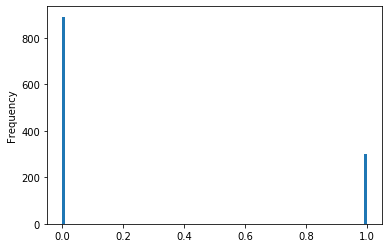

In [16]:
dados[target].plot.hist(bins = 100)

### 2.5 Correlação
Queremos ver quais as variáveis que estão mais relacionadas com o target de alguma forma.

*Meses desempregado* parece ser uma variável bem forte.

In [17]:
dados.corr(method='pearson')[target].sort_values()

GastoMax              -0.03
GastoMedio            -0.03
PerfilEconomico       -0.03
ValorCompraAnual      -0.03
Idade                 -0.02
PerfilCompra           0.01
NumeroComprasOnline    0.02
MesesDesempregado      0.32
Anuidade               0.61
Target                 1.00
Name: Target, dtype: float64

É importante olhar como as features estão relacionadas entre si. 

Por exemplo, não queremos usar duas features muito correlacionadas no modelo ao mesmo tempo.

In [18]:
dados.corr()

,PerfilEconomico,Idade,PerfilCompra,ValorCompraAnual,GastoMax,GastoMedio,NumeroComprasOnline,MesesDesempregado,Anuidade,Target
PerfilEconomico,1.00,-0.32,0.08,-0.26,-0.27,-0.27,-0.06,0.01,-0.03,-0.03
Idade,-0.32,1.00,-0.07,0.05,0.05,0.05,-0.03,-0.03,-0.03,-0.02
PerfilCompra,0.08,-0.07,1.00,-0.04,-0.04,-0.04,-0.02,0.03,0.01,0.01
ValorCompraAnual,-0.26,0.05,-0.04,1.00,1.00,1.00,0.08,-0.03,0.00,-0.03
GastoMax,-0.27,0.05,-0.04,1.00,1.00,1.00,0.08,-0.03,-0.00,-0.03
GastoMedio,-0.27,0.05,-0.04,1.00,1.00,1.00,0.08,-0.03,-0.00,-0.03
NumeroComprasOnline,-0.06,-0.03,-0.02,0.08,0.08,0.08,1.00,-0.00,0.01,0.02
MesesDesempregado,0.01,-0.03,0.03,-0.03,-0.03,-0.03,-0.00,1.00,0.19,0.32
Anuidade,-0.03,-0.03,0.01,0.00,-0.00,-0.00,0.01,0.19,1.00,0.61
Target,-0.03,-0.02,0.01,-0.03,-0.03,-0.03,0.02,0.32,0.61,1.00


## 3. Tratamento dos Dados
Imputação, dummies. Geracao da ABT de modelagem

In [19]:
dados.head()

,PerfilEconomico,Sexo,Idade,PerfilCompra,ValorCompraAnual,GastoMax,GastoMedio,UF,CidadeResidencia,RegiaodoPais,NumeroComprasOnline,MesesDesempregado,Anuidade,Target
0,2,mulher,24,2,1875.00,133.93,156.25,MA,Centro Novo do Maranhão,Região Nordeste,13.02,2,251.19,1
1,3,mulher,22,0,725.00,51.79,60.42,PI,Amarante,Região Nordeste,5.49,13,233.54,1
2,3,homem,22,0,72292.00,5163.71,6024.33,MT,Santo Antônio do Leverger,Região Centro-Oeste,547.67,2,275.44,1
3,3,homem,22,1,155.00,11.07,12.92,PR,Quitandinha,Região Sul,1.17,13,2.00,1
4,2,mulher,15,1,26.00,1.86,2.17,SP,Nova Campina,Região Sudeste,0.29,7,249.33,1


In [76]:
target = dados['Target']
train_set, test_set, y_train, y_test = train_test_split(dados,
                                                        target,
                                                        test_size=0.3,
                                                        random_state=42)

### 3.1 Imputação

Imputação de mediana nas variáveis numéricas (no caso serve apenas para ValorCompraAnual).

Imputação de `unk` (para unknown) para as variáveis categóricas (não se aplica para essa base).

In [77]:
from fklearn.training.imputation import imputer, placeholder_imputer
from toolz import compose

num_impute_learner = imputer(columns_to_impute=["ValorCompraAnual"],#, "GastoMax", "GastoMedio", "NumeroComprasOnline", "MesesDesempregado", "Anuidade"],
                             impute_strategy="median")

cat_impute_learner = placeholder_imputer(columns_to_impute=["PerfilEconomico", "Sexo", "RegiaodoPais", "PerfilCompra", "UF", "CidadeResidencia"],
                                          placeholder_value="unk")

#tupla que retorna: [0] a funcao, [1] dataset e [2] log
num_impute_fn, _, num_impute_log = num_impute_learner(train_set)
cat_impute_fn, _, cat_impute_log = cat_impute_learner(train_set)

compose(num_impute_fn, cat_impute_fn)(train_set).isnull().mean()

PerfilEconomico       0.00
Sexo                  0.00
Idade                 0.00
PerfilCompra          0.00
ValorCompraAnual      0.00
GastoMax              0.00
GastoMedio            0.00
UF                    0.00
CidadeResidencia      0.00
RegiaodoPais          0.00
NumeroComprasOnline   0.00
MesesDesempregado     0.00
Anuidade              0.00
Target                0.00
dtype: float64

### 3.2 Tratamento Outliers, Dummies e Label encoder
Aplica-se um **capper** para valores acima de um certo valor. Não se aplica na base, mas poderiamos usar o **foorer** para aplicar um threshold inferior.

**One hot encoder** para variáveis categóricas com baixa cardinalidade.

**Label encoder** para variáveis categóricas com alta cardinalidade.

In [78]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
dados.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PerfilEconomico,1191.00,2.29,0.84,1.00,2.00,3.00,3.00,3.00
Idade,1191.00,30.27,12.36,10.00,22.00,26.00,36.00,92.00
PerfilCompra,1191.00,0.53,1.08,0.00,0.00,0.00,1.00,8.00
ValorCompraAnual,1163.00,108034.13,366794.50,0.00,167.00,2625.00,78667.00,5123292.00
GastoMax,1191.00,7834.60,26481.77,0.00,11.71,187.50,5610.14,365949.43
GastoMedio,1191.00,9140.37,30895.40,0.00,13.67,218.75,6545.17,426941.00
NumeroComprasOnline,1191.00,66806.38,1404381.47,0.00,1.16,13.21,559.97,34107625.00
MesesDesempregado,1191.00,5.09,3.48,0.00,2.00,5.00,8.00,14.00
Anuidade,1191.00,83.57,69.07,0.01,33.55,69.10,107.13,309.38
Target,1191.00,0.25,0.43,0.00,0.00,0.00,1.00,1.00


In [104]:
from fklearn.training.transformation import capper, floorer
from fklearn.training.transformation import label_categorizer
from fklearn.training.transformation import onehot_categorizer

# Capping altos: ValorCompraAnual, GastoMax, GastoMax, GastoMedio e NumeroComprasOnline
capper_fn = capper(columns_to_cap=['ValorCompraAnual', 'GastoMax', 'GastoMedio', 'NumeroComprasOnline'], 
                   precomputed_caps={'ValorCompraAnual': 500000,
                                     'GastoMax': 50000,
                                     'GastoMedio': 30000,
                                     'NumeroComprasOnline': 10000
                                    })

# One hot encoding (cria dummies)
categorical_features_onehot = ['PerfilEconomico', 'Sexo', 'PerfilCompra', 'RegiaodoPais']
oh_encode_learner = onehot_categorizer(columns_to_categorize=categorical_features_onehot,
                                       hardcode_nans=False, # hardcodes an extra column with 1 if nan or unseen else 0
                                       drop_first_column=True)

# Label encoding
le_encode_learner = label_categorizer(
                                columns_to_categorize=['UF', 'CidadeResidencia'],
                                store_mapping=True,
)

## 4. Pipeline

In [132]:
from fklearn.training.pipeline import build_pipeline

pipeline_learner = build_pipeline(
    capper_fn,
    num_impute_learner,
    cat_impute_learner,
    oh_encode_learner,
    le_encode_learner
)

In [133]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 296 to 826
Data columns (total 14 columns):
PerfilEconomico        833 non-null int64
Sexo                   833 non-null object
Idade                  833 non-null int64
PerfilCompra           833 non-null int64
ValorCompraAnual       814 non-null float64
GastoMax               833 non-null float64
GastoMedio             833 non-null float64
UF                     833 non-null object
CidadeResidencia       833 non-null object
RegiaodoPais           833 non-null object
NumeroComprasOnline    833 non-null float64
MesesDesempregado      833 non-null int64
Anuidade               833 non-null float64
Target                 833 non-null int64
dtypes: float64(5), int64(5), object(4)
memory usage: 97.6+ KB


In [149]:
# using pipeline
# tupla que retorna: [0] a funcao, [1] dataset e [2] log
p_train, train_df, log_train = pipeline_learner(train_set)
p_test, test_df, log_test = pipeline_learner(test_set)

In [150]:
train_df.columns

Index(['Idade', 'ValorCompraAnual', 'GastoMax', 'GastoMedio', 'UF',
       'CidadeResidencia', 'NumeroComprasOnline', 'MesesDesempregado',
       'Anuidade', 'Target', 'fklearn_feat__PerfilEconomico==1',
       'fklearn_feat__PerfilEconomico==2', 'fklearn_feat__PerfilEconomico==3',
       'fklearn_feat__Sexo==homem', 'fklearn_feat__Sexo==mulher',
       'fklearn_feat__PerfilCompra==0', 'fklearn_feat__PerfilCompra==1',
       'fklearn_feat__PerfilCompra==2', 'fklearn_feat__PerfilCompra==3',
       'fklearn_feat__PerfilCompra==4', 'fklearn_feat__PerfilCompra==5',
       'fklearn_feat__PerfilCompra==8',
       'fklearn_feat__RegiaodoPais==Região Centro-Oeste',
       'fklearn_feat__RegiaodoPais==Região Nordeste',
       'fklearn_feat__RegiaodoPais==Região Norte',
       'fklearn_feat__RegiaodoPais==Região Sudeste',
       'fklearn_feat__RegiaodoPais==Região Sul'],
      dtype='object')

## 5. Métodos de Seleção
Filtro, wrapper, embedded

In [151]:
cols = ['Target', 'fklearn_feat__PerfilEconomico==3', 'fklearn_feat__Sexo==mulher', 'fklearn_feat__PerfilCompra==8','fklearn_feat__RegiaodoPais==Região Sul']
train_df_copy = train_df
test_df_copy = test_df
for col in cols:
    if col in train_df_copy.columns:
        train_df_copy = train_df_copy.drop(columns=col, axis=1)
    if col in test_df_copy.columns:
        test_df_copy = test_df_copy.drop(columns=col, axis=1)

explicativas_train = train_df_copy
target_train = train_df['Target']

explicativas_test = test_df_copy
target_test = test_df['Target']

### 5.1 Baseado em Filtro

In [152]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

x_norm = MinMaxScaler().fit_transform(explicativas)

# chamada do objeto
chi2_selector = SelectKBest(chi2)

chi2_selector.fit(x_norm, target)

chi_s = chi2_selector.get_support()

chi_feature = explicativas.loc[:,chi_s].columns.tolist()
print(str(len(chi_feature)), 'variaveis selecionadas')
print(chi_feature)

10 variaveis selecionadas
['ValorCompraAnual', 'GastoMedio', 'CidadeResidencia', 'MesesDesempregado', 'Anuidade', 'fklearn_feat__Sexo==homem', 'fklearn_feat__PerfilCompra==0', 'fklearn_feat__PerfilCompra==1', 'fklearn_feat__PerfilCompra==5', 'fklearn_feat__RegiaodoPais==Região Norte']


### 5.2 Wrapper

In [153]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# chamada do objeto
rfe_selector = RFE(estimator=LogisticRegression(), step=10) #default is half, n_features_to_select=10)

rfe_selector.fit(explicativas, target)
rfe_support = rfe_selector.get_support()
rfe_feature = explicativas.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'variaveis selecionadas:')
print(rfe_feature)

11 variaveis selecionadas:
['Idade', 'UF', 'MesesDesempregado', 'Anuidade', 'fklearn_feat__PerfilEconomico==1', 'fklearn_feat__PerfilEconomico==2', 'fklearn_feat__Sexo==homem', 'fklearn_feat__PerfilCompra==0', 'fklearn_feat__PerfilCompra==1', 'fklearn_feat__RegiaodoPais==Região Nordeste', 'fklearn_feat__RegiaodoPais==Região Sudeste']


/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 5.3 Random Forest

In [154]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

em_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
em_selector.fit(explicativas, target)

em_sup = em_selector.get_support()
em_feature = explicativas.loc[:,em_sup].columns.tolist()
print(str(len(em_feature)), 'variaveis selecionadas:')
print(em_feature)

3 variaveis selecionadas:
['CidadeResidencia', 'MesesDesempregado', 'Anuidade']


### 5.4 Comparando Filtro, Wrapper e Random Forest

In [155]:
feature_selection_df = pd.DataFrame({'Variaveis':explicativas.columns,
                                     'chi2':chi_s,
                                     'RFE': rfe_support,
                                     'Random forest': em_sup})
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
feature_selection_df = feature_selection_df.sort_values(['Total', 'Variaveis'], ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

Selecionando features que apareceram em pelo menos dois métodos de seleção de variáveis:

In [157]:
var_select = feature_selection_df[feature_selection_df['Total'] > 1]['Variaveis'].tolist()

In [169]:
x_treino = explicativas_train[var_select]
y_treino = target_train

x_teste = explicativas_test[var_select]
y_teste = target_test

## 6. Modelagem usando Gridsearch e Cross Validation Kfold: Regressao Logística, Random Forest e Gradient Boosting)

### 6.1.1 Regressão Logística

In [340]:
from sklearn.linear_model import LogisticRegression
RL = LogisticRegression(random_state=42)

Dicionário de hyperparâmetros para o **GridSearch** da Regressão Logística

In [341]:
hyperparameters = {"C":np.logspace(-3,3,7), 
                   "penalty":["l1","l2"]} # l1 lasso l2 ridge

In [342]:
grid_RL = GridSearchCV(RL, 
                  hyperparameters, 
                  cv=10,
                  verbose=0)
grid_RL.fit(x_treino, y_treino)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [343]:
grid_RL.best_params_

{'C': 1.0, 'penalty': 'l1'}

Passo os melhores parametros do Gridsearch como argumentos na LogisticRegression():

In [344]:
RL = LogisticRegression(**grid_RL.best_params_, random_state=42)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [345]:
from sklearn.model_selection import cross_val_score
acuracias_RL_treino = cross_val_score(estimator=RL,
                            X = x_treino,
                            y = y_treino,
                            cv=10)

acuracias_RL_teste = cross_val_score(estimator=RL,
                            X = x_teste,
                            y = y_teste,
                            cv=10)

/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/jaime.mishima/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarn

In [346]:
print('REGRESSAO LOGISTICA - Acuracia de Treino:',round(acuracias_RL_treino.mean()*100,2))
print('REGRESSAO LOGISTICA - Acuracia de Teste:',round(acuracias_RL_teste.mean()*100,2))

REGRESSAO LOGISTICA - Acuracia de Treino: 89.33
REGRESSAO LOGISTICA - Acuracia de Teste: 87.96


### 6.1.2 Random Forest

Dicionário de hyperparâmetros para o **GridSearch** da Random Forest

In [347]:
from sklearn.ensemble import RandomForestClassifier

parametros_grid = {
    'n_estimators':[10,20,50,100,200,500],
    'criterion':['gini', 'entropy'],
    'bootstrap':[True, False]
}

RF = RandomForestClassifier(random_state=123)

In [348]:
from sklearn.model_selection import GridSearchCV

grid_RF = GridSearchCV(estimator=RF,
                    param_grid=parametros_grid,
                    scoring='accuracy',
                    cv=5)
grid_RF.fit(x_treino, y_treino)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={

In [302]:
grid_RF.best_params_

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100}

In [349]:
grid_RF.best_score_

0.9267707082833133

Passo os melhores parâmetros do Gridsearch como argumentos na RandomForestClassifier():

In [350]:
RF = RandomForestClassifier(**grid_RF.best_params_, random_state=42)
RF.fit(x_treino, y_treino)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [351]:
from sklearn.model_selection import cross_val_score
acuracias_RF_treino = cross_val_score(estimator=RF,
                            X = x_treino,
                            y = y_treino,
                            cv=10)

acuracias_RF_teste = cross_val_score(estimator=RF,
                            X = x_teste,
                            y = y_teste,
                            cv=10)

In [352]:
print('RANDOM FOREST - Acuracia de Treino:',round(acuracias_RF_treino.mean()*100,2))
print('RANDOM FOREST - Acuracia de Teste:',round(acuracias_RF_teste.mean()*100,2))

RANDOM FOREST - Acuracia de Treino: 92.45
RANDOM FOREST - Acuracia de Teste: 92.19


### 6.1.3 Gradient Boosting

In [353]:
from sklearn.ensemble import GradientBoostingClassifier

GB = GradientBoostingClassifier(random_state=42)

Dicionário de hyperparâmetros para o **GridSearch** do Gradient Boosting

In [354]:
parametros_gb = {'min_samples_split': [0.1, 0.5, 1.0, 3, 5],
                 'min_samples_leaf': [0.1, 0.5, 1, 3, 5],
                 'max_depth': [2,3,5,10],
                 'n_estimators':[2,5,10,15]}

In [355]:
from sklearn.model_selection import GridSearchCV

# assinatura do objeto
grid_GB = GridSearchCV(estimator=GB,
                       param_grid=parametros_gb,
                       cv=5,
                       n_jobs=-1) # tenta rodar em paralelo, se possível
grid_GB.fit(x_treino, y_treino)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...e,
                                                  presort='auto',


In [356]:
grid_GB.best_score_

0.9339735894357744

In [357]:
grid_GB.best_params_

{'max_depth': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 0.1,
 'n_estimators': 5}

Passo os melhores parâmetros do Gridsearch como argumentos na RandomForestClassifier():

In [358]:
GB = GradientBoostingClassifier(**grid_GB.best_params_, random_state=42)
GB.fit(x_treino, y_treino)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.1,
                           min_weight_fraction_leaf=0.0, n_estimators=5,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

**Cross Validation** com o melhor modelo dado pelo GridSearch acima:

In [359]:
from sklearn.model_selection import cross_val_score
acuracias_GB_treino = cross_val_score(estimator=GB,
                            X = x_treino,
                            y = y_treino,
                            cv=5)

acuracias_GB_teste = cross_val_score(estimator=GB,
                            X = x_teste,
                            y = y_teste,
                            cv=5)

In [360]:
print('GRADIENT BOOSTING - Acuracia de Treino:',round(acuracias_GB_treino.mean()*100,2))
print('GRADIENT BOOSTING - Acuracia de Teste:',round(acuracias_GB_teste.mean()*100,2))

GRADIENT BOOSTING - Acuracia de Treino: 93.4
GRADIENT BOOSTING - Acuracia de Teste: 92.73


### 6.1.4 Comparando Modelos

In [361]:
modelos = pd.DataFrame({'Modelo': ['Regressao Logistica',
                                   'Random Forest',
                                   'Gradient Boosting'],
                        'Acuracia_treino':[round(acuracias_RL_treino.mean()*100,2), 
                                           round(acuracias_RF_treino.mean()*100,2),
                                           round(acuracias_GB_treino.mean()*100,2)],
                        'Acuracia_teste':[round(acuracias_RL_teste.mean()*100,2), 
                                          round(acuracias_RF_teste.mean()*100,2),
                                          round(acuracias_GB_teste.mean()*100,2)]
                       })

comparacao = modelos.sort_values(by='Acuracia_teste', ascending=False)
comparacao = comparacao[['Modelo', 'Acuracia_treino', 'Acuracia_teste']]

In [362]:
comparacao

,Modelo,Acuracia_treino,Acuracia_teste
2,Gradient Boosting,93.40,92.73
1,Random Forest,92.45,92.19
0,Regressao Logistica,89.33,87.96


## 7. Salvando Modelo

Melhores estimadores do melhor modelo (com maior acurácia foi o Gradient Boosting):

In [364]:
grid_GB.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.1,
                           min_weight_fraction_leaf=0.0, n_estimators=5,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [366]:
from sklearn.externals import joblib

joblib.dump(grid_GB.best_estimator_, 'modelo_gb_cartao.pkl', compress = 1)

['modelo_gb_cartao.pkl']

## 8. Recuperando Modelo Salvo

In [367]:
modelo_treinado = open('modelo_gb_cartao.pkl', 'rb')
model = joblib.load(modelo_treinado)

In [368]:
model.predict(x_teste)

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,

In [369]:
model.predict_proba(x_teste)[:,1]

array([0.17770197, 0.56229525, 0.56229525, 0.56229525, 0.17770197,
       0.17770197, 0.17770197, 0.56229525, 0.17770197, 0.17770197,
       0.17770197, 0.17770197, 0.17770197, 0.17770197, 0.17770197,
       0.56229525, 0.17770197, 0.17770197, 0.17770197, 0.56229525,
       0.17770197, 0.17770197, 0.56229525, 0.17770197, 0.56229525,
       0.56229525, 0.17770197, 0.17770197, 0.17770197, 0.17770197,
       0.17770197, 0.17770197, 0.17770197, 0.17770197, 0.17770197,
       0.17770197, 0.56229525, 0.17770197, 0.56229525, 0.17770197,
       0.56229525, 0.17770197, 0.17770197, 0.17770197, 0.17770197,
       0.17770197, 0.17770197, 0.17770197, 0.17770197, 0.17770197,
       0.17770197, 0.17770197, 0.17770197, 0.17770197, 0.17770197,
       0.17770197, 0.17770197, 0.17770197, 0.17770197, 0.17770197,
       0.17770197, 0.56229525, 0.56229525, 0.17770197, 0.17770197,
       0.17770197, 0.17770197, 0.17770197, 0.17770197, 0.17770197,
       0.17770197, 0.17770197, 0.17770197, 0.17770197, 0.17770